## Multi-Information Source BO with Augmented Gaussian Processes
- Contributors: andreaponti5
- Last updated: Jan 29, 2024
- BoTorch version: 0.9.5(dev)

In this tutorial, we show how to perform Multiple Information Source Bayesian Optimization in BoTorch based on the Augmented Gaussian Process (AGP) and the Augmented UCB (AUCB) acquisition function proposed in [1].
The key idea of the AGP is to fit a GP model for each information source and *augment* the observations on the high fidelity source with those from *cheaper* sources which can be considered as *reliable*. The GP model fitted on this *augmented* set of observations is the AGP.
The AUCB is a modification of the standard UCB -- computed on the AGP -- suitably proposed to also deal with the source-specific query cost.

We emprically show that the *AGP-based* Multiple Information Source Basyesian Optimization usually performs better than other multi-fidelity approaches [2].

[1] [Candelieri, A., & Archetti, F. (2021). Sparsifying to optimize over multiple information sources: an augmented Gaussian process based algorithm. Structural and Multidisciplinary Optimization, 64, 239-255.](https://link.springer.com/article/10.1007/s00158-021-02882-7)
[2] [The arxiv will be available soon.](https://arxiv.org/)


In [1]:
!pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import matplotlib.pyplot as plt

import torch
from gpytorch import ExactMarginalLogLikelihood

import botorch
from botorch import fit_gpytorch_mll
from botorch.acquisition import InverseCostWeightedUtility, qMultiFidelityMaxValueEntropy
from botorch_community.acquisition.augmented_multisource import AugmentedUpperConfidenceBound
from botorch.models import AffineFidelityCostModel, SingleTaskMultiFidelityGP
from botorch_community.models.gp_regression_multisource import SingleTaskAugmentedGP, get_random_x_for_agp
from botorch.models.transforms import Standardize
from botorch.optim import optimize_acqf, optimize_acqf_mixed
from botorch.test_functions.multi_fidelity import AugmentedBranin

In [3]:
tkwargs = {
    "dtype": torch.double,
    "device": torch.device("cuda" if torch.cuda.is_available() else "cpu"),
}
SMOKE_TEST = os.environ.get("SMOKE_TEST", False)

In [4]:
N_ITER = 10 if SMOKE_TEST else 50
SEED = 3

### Problem setup
We consider the augmented Branin multi-fidelity synthetic test problem. It is important to clarify that *augmented* is not about the AGP: here, it has a different meaning. It means that the Branin test function has been modified by introducing an additional dimension representing the fidelity parameter.

The test function takes the form $f(x,s)$ where $x \in [-5, 10] \times [0, 15]$ and $s \in [0,1]$. The target fidelity is 1.0, which means that our goal is to solve $\max_x f(x,1.0)$ by making use of cheaper evaluations $f(x,s)$ for $s < 1.0$. In this example, we'll assume that the cost function takes the form $5.0 + s$, illustrating a situation where the fixed cost is $5.0$.

Since a multiple information source context is considered, three different sources are considered, with $s = 0.5, 0.75, 1.00$, respectively.

In [5]:
problem = AugmentedBranin(negate=True).to(**tkwargs)
fidelities = torch.tensor([0.5, 0.75, 1.0], **tkwargs)
n_sources = fidelities.shape[0]

bounds = torch.tensor([[-5, 0, 0], [10, 15, n_sources - 1]], **tkwargs)
target_fidelities = {n_sources - 1: 1.0}

cost_model = AffineFidelityCostModel(fidelity_weights=target_fidelities, fixed_cost=5.0)
cost_aware_utility = InverseCostWeightedUtility(cost_model=cost_model)

### Model initialization

We use a `SingleTaskAugmentedGP` to implement our AGP.

At each Bayesian Optimization iteration, the set of observations from the *ground-truth* (i.e., the highest fidelity and more expensive source) is temporarily *augmented* by including observations from the other cheap sources, only if they can be considered *reliable*. Specifically, an observation $(x,y)$ from a cheap source is considered reliable if it satisfies the following inequality:

$$\vert\mu(x)-y\vert \leq m \sigma(x)$$

where $\mu(x)$ and $\sigma(x)$ are, respectively, the posterior mean and standard deviation of the GP model fitted on the high fidelity observations only, and $m$ is a technical parameter making more *conservative* ($m→0$) or *inclusive* ($m→∞)$ the augmentation process. As reported in [1], a suitable value for this parameter is $m=1$.

After the set of observations is augmented, the AGP is fitted through `SingleTaskAugmentedGP`.


In [6]:
def generate_initial_data(n):
    train_x = get_random_x_for_agp(n, bounds, 1)
    xs = train_x[..., :-1]
    fids = fidelities[train_x[..., -1].int()].reshape(-1, 1)
    train_obj = problem(torch.cat((xs, fids), dim=1)).unsqueeze(-1)
    return train_x, train_obj


def initialize_model(train_x, train_obj, m):
    model = SingleTaskAugmentedGP(
        train_x, train_obj, m=m, outcome_transform=Standardize(m=1),
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

#### Define a helper function that performs the essential BO step
This helper function optimizes the acquisition function and returns the candidate point along with the observed function values.

The UCB acquisition function has been modified to deal with both the *discrepancy* between information sources and the *source-specific query cost*.

Formally, the AUCB acquisition function, at a generic iteration $t$, is defined as:

$$\alpha_s(x,\hat y^+) = \frac{\left[\hat{\mu}(x) + \sqrt{\beta^{(t)}} \hat{\sigma}(x)\right] - \hat{y}^+}{c_s \cdot (1+\vert \hat{\mu}(x) - \mu_s(x) \vert)} $$

where $\hat{y}^+$ is the best (i.e., highest) value in the *augmented* set of observations, the numerator is -- therefore -- the optimistic improvement with respect to $\hat{y}^+$, $c_s$ is the query cost for the source $s$, and $\vert \hat{\mu}(x) - \mu_s(x) \vert$ is a discrepancy measure between the predictions provided by the AGP and the GP on the source $s$, respectively, given the input $x$ (i.e., 1 is added just to avoid division by zero).

For more information, please refer to [1],

In [7]:
def optimize_aucb(acqf):
    candidate, value = optimize_acqf(
        acq_function=acqf,
        bounds=bounds,
        q=1,
        num_restarts=5,
        raw_samples=128,
    )
    # observe new values
    new_x = candidate.detach()
    new_x[:, -1] = torch.round(new_x[:, -1], decimals=0)
    return new_x

### Perform a few steps of multi-fidelity BO
First, let's generate some initial random data and fit a surrogate model.

In [8]:
torch.manual_seed(SEED)
train_x, train_obj = generate_initial_data(n=5)

We can now use the helper functions above to run a few iterations of BO.

In [9]:
cumulative_cost = 0.0

with botorch.settings.validate_input_scaling(False):
    for it in range(N_ITER):
        mll, model = initialize_model(train_x, train_obj, m=1)
        fit_gpytorch_mll(mll)
        acqf = AugmentedUpperConfidenceBound(
            model,
            beta=3,
            maximize=True,
            best_f=train_obj[torch.where(train_x[:, -1] == 0)].min(),
            cost={i: fid + 5.0 for i, fid in enumerate(fidelities)},
        )
        new_x = optimize_aucb(acqf)
        if model.n_true_points < model.max_n_cheap_points:
            new_x[:, -1] = fidelities.shape[0] - 1
        train_x = torch.cat([train_x, new_x])

        new_x[:, -1] = fidelities[new_x[:, -1].int()]
        new_obj = problem(new_x).unsqueeze(-1)
        train_obj = torch.cat([train_obj, new_obj])

        print(
            f"Iter {it};"
            f"\t Fid = {new_x[0].tolist()[-1]:.2f};"
            f"\t Obj = {new_obj[0][0].tolist():.4f};"
        )

Iter 0;	 Fid = 1.00;	 Obj = -12.0999;
Iter 1;	 Fid = 1.00;	 Obj = -50.0743;
Iter 2;	 Fid = 0.50;	 Obj = -11.9672;
Iter 3;	 Fid = 0.50;	 Obj = -8.7046;
Iter 4;	 Fid = 0.50;	 Obj = -13.3425;
Iter 5;	 Fid = 1.00;	 Obj = -11.6850;
Iter 6;	 Fid = 0.50;	 Obj = -8.2926;
Iter 7;	 Fid = 1.00;	 Obj = -14.4455;
Iter 8;	 Fid = 0.50;	 Obj = -16.5711;
Iter 9;	 Fid = 1.00;	 Obj = -32.7208;
Iter 10;	 Fid = 0.50;	 Obj = -12.7833;
Iter 11;	 Fid = 1.00;	 Obj = -40.2770;
Iter 12;	 Fid = 0.50;	 Obj = -4.8935;
Iter 13;	 Fid = 1.00;	 Obj = -15.2650;
Iter 14;	 Fid = 0.50;	 Obj = -6.9511;
Iter 15;	 Fid = 1.00;	 Obj = -18.1231;
Iter 16;	 Fid = 0.50;	 Obj = -0.6015;
Iter 17;	 Fid = 1.00;	 Obj = -17.0770;
Iter 18;	 Fid = 0.50;	 Obj = -4.3991;
Iter 19;	 Fid = 1.00;	 Obj = -12.4392;
Iter 20;	 Fid = 1.00;	 Obj = -112.9747;
Iter 21;	 Fid = 0.50;	 Obj = -4.6979;
Iter 22;	 Fid = 0.50;	 Obj = -13.1965;
Iter 23;	 Fid = 1.00;	 Obj = -14.2637;
Iter 24;	 Fid = 0.50;	 Obj = -16.4335;
Iter 25;	 Fid = 1.00;	 Obj = -1.4522;
Ite

## Comparison to MES

In [10]:
def initialize_mes_model(train_x, train_obj, data_fidelity):
    model = SingleTaskMultiFidelityGP(
        train_x,
        train_obj,
        outcome_transform=Standardize(m=1),
        data_fidelity=data_fidelity,
    )
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    return mll, model

In [11]:
def optimize_mes_and_get_observation(mes_acq, fixed_features_list):
    candidates, acq_value = optimize_acqf_mixed(
        acq_function=mes_acq,
        bounds=problem.bounds,
        q=1,
        num_restarts=5,
        raw_samples=128,
        fixed_features_list=fixed_features_list,
    )
    # observe new values
    cost = cost_model(candidates).sum()
    new_x = candidates.detach()
    new_obj = problem(new_x).unsqueeze(-1)
    return new_x, new_obj, cost

In [12]:
train_x_mes = torch.clone(train_x[:10])
train_x_mes[:, -1] = fidelities[train_x_mes[:, -1].int()]
train_obj_mes = torch.clone(train_obj[:10])

In [13]:
candidate_set = torch.rand(
    1000, problem.bounds.size(1), device=problem.bounds.device, dtype=problem.bounds.dtype
)
candidate_set = problem.bounds[0] + (problem.bounds[1] - problem.bounds[0]) * candidate_set

cumulative_cost = 0.0

with botorch.settings.validate_input_scaling(False):
    for it in range(N_ITER):
        mll, model = initialize_mes_model(train_x_mes, train_obj_mes, data_fidelity=2)
        fit_gpytorch_mll(mll)
        acqf = qMultiFidelityMaxValueEntropy(
            model, candidate_set, cost_aware_utility=cost_aware_utility
        )
        new_x, new_obj, cost = optimize_mes_and_get_observation(acqf,
                                                                fixed_features_list=[{2: fid} for fid in fidelities])
        train_x_mes = torch.cat([train_x_mes, new_x])
        train_obj_mes = torch.cat([train_obj_mes, new_obj])
        cumulative_cost += cost
        print(
            f"Iter {it};"
            f"\t Fid = {new_x[0].tolist()[-1]:.2f};"
            f"\t Obj = {new_obj[0][0].tolist():.4f};"
        )

Iter 0;	 Fid = 0.50;	 Obj = -8.3276;
Iter 1;	 Fid = 0.50;	 Obj = -21.1510;
Iter 2;	 Fid = 0.50;	 Obj = -20.7855;
Iter 3;	 Fid = 0.50;	 Obj = -8.5067;
Iter 4;	 Fid = 0.50;	 Obj = -49.7241;
Iter 5;	 Fid = 0.50;	 Obj = -1.3525;
Iter 6;	 Fid = 0.50;	 Obj = -98.0777;
Iter 7;	 Fid = 0.50;	 Obj = -88.9142;
Iter 8;	 Fid = 0.50;	 Obj = -1.3561;
Iter 9;	 Fid = 1.00;	 Obj = -135.8402;
Iter 10;	 Fid = 0.50;	 Obj = -16.4201;
Iter 11;	 Fid = 0.50;	 Obj = -125.3250;
Iter 12;	 Fid = 0.50;	 Obj = -6.7582;
Iter 13;	 Fid = 0.50;	 Obj = -61.3218;
Iter 14;	 Fid = 0.50;	 Obj = -19.6356;
Iter 15;	 Fid = 0.50;	 Obj = -91.3633;
Iter 16;	 Fid = 0.50;	 Obj = -90.9424;
Iter 17;	 Fid = 0.50;	 Obj = -22.3466;
Iter 18;	 Fid = 0.50;	 Obj = -1.9025;
Iter 19;	 Fid = 0.50;	 Obj = -16.0446;
Iter 20;	 Fid = 0.50;	 Obj = -13.2516;
Iter 21;	 Fid = 0.50;	 Obj = -23.5304;
Iter 22;	 Fid = 0.50;	 Obj = -8.6583;
Iter 23;	 Fid = 0.50;	 Obj = -19.9776;
Iter 24;	 Fid = 0.50;	 Obj = -22.8034;
Iter 25;	 Fid = 0.50;	 Obj = -11.0479;
I

## Plot results

In [14]:
mapping_fid = dict(zip(range(fidelities.shape[0]), fidelities.tolist()))
cost_AGP = torch.cumsum(torch.tensor([mapping_fid[int(source)] for source in train_x[:, -1].tolist()]), dim=0)
cost_MES = torch.cumsum(train_x_mes[:, -1], dim=0)

In [15]:
train_obj[torch.where(train_x[:, -1] != fidelities.shape[0] - 1)] = train_obj.min()
best_seen_AGP = torch.cummax(train_obj, dim=0)[0]

In [16]:
train_obj_mes[torch.where(train_x_mes[:, -1] != 1)[0]] = train_obj_mes.min()
best_seen_MES = torch.cummax(train_obj_mes, dim=0)[0]

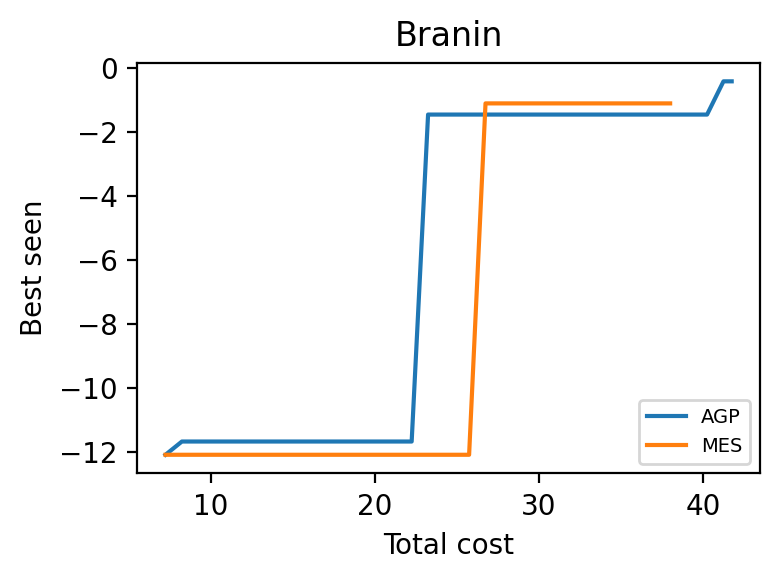

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=200)
ax.plot(
    cost_AGP.cpu()[9:],
    best_seen_AGP.cpu()[9:],
    label="AGP"
)
ax.plot(
    cost_MES.cpu()[9:],
    best_seen_MES.cpu()[9:],
    label="MES"
)

ax.set_title("Branin", fontsize="12")
ax.set_xlabel("Total cost", fontsize="10")
ax.set_ylabel("Best seen", fontsize="10")
ax.tick_params(labelsize=10)
ax.legend(loc="lower right", fontsize="7", frameon=True, ncol=1)
plt.tight_layout()